# 03. Synthetic Data Evaluation

This notebook evaluates Random Forest, CatBoost, and a Stacking Ensemble (RF + CatBoost) across various synthetic datasets generated with different imputation and synthesis methods.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, balanced_accuracy_score
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Define Evaluation Framework

We will iterate through all directories in `data/synthetic` (representing imputation methods) and all files within them (representing synthesis methods).

In [2]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = {}
    
    # 1. Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RF'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_rf),
        'f1_weighted': f1_score(y_test, y_pred_rf, average='weighted')
    }
    
    # 2. CatBoost
    cb = CatBoostClassifier(iterations=500, random_seed=42, verbose=0)
    cb.fit(X_train, y_train)
    y_pred_cb = cb.predict(X_test)
    results['CatBoost'] = {
        'accuracy': accuracy_score(y_test, y_pred_cb),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_cb),
        'f1_weighted': f1_score(y_test, y_pred_cb, average='weighted')
    }
    
    # 3. Stacking (RF + CatBoost)
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('cb', CatBoostClassifier(iterations=500, random_seed=42, verbose=0))
    ]
    stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    stacking.fit(X_train, y_train)
    y_pred_stack = stacking.predict(X_test)
    results['Stacking'] = {
        'accuracy': accuracy_score(y_test, y_pred_stack),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_stack),
        'f1_weighted': f1_score(y_test, y_pred_stack, average='weighted')
    }
    
    return results

## 2. Run Iteration over All Datasets

In [3]:
synthetic_root = '../data/synthetic'
all_results = []

for imputation_method in os.listdir(synthetic_root):
    imputation_path = os.path.join(synthetic_root, imputation_method)
    if not os.path.isdir(imputation_path): continue
    
    for file in os.listdir(imputation_path):
        if not file.endswith('.csv'): continue
        
        synthesis_method = file.replace('uc_diagnostics_', '').replace('.csv', '')
        file_path = os.path.join(imputation_path, file)
        
        # Load data
        df = pd.read_csv(file_path)
        
        # Prepare features and target
        X = df.drop(columns=['mayo'])
        y = df['mayo']
        
        # Split data (ensure stratified split since Mayo can be imbalanced)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        print(f"Processing: Imputation={imputation_method}, Synthesis={synthesis_method}...")
        
        exp_results = train_and_evaluate(X_train, X_test, y_train, y_test)
        
        for model_name, metrics in exp_results.items():
            row = {
                'imputation': imputation_method,
                'synthesis': synthesis_method,
                'model': model_name,
                **metrics
            }
            all_results.append(row)

results_df = pd.DataFrame(all_results)
print("Done!")

Processing: Imputation=knn, Synthesis=ctgan...
Processing: Imputation=knn, Synthesis=adasyn...
Processing: Imputation=knn, Synthesis=tvae...
Processing: Imputation=softimpute, Synthesis=ctgan...
Processing: Imputation=softimpute, Synthesis=adasyn...
Processing: Imputation=softimpute, Synthesis=tvae...
Processing: Imputation=gain, Synthesis=ctgan...
Processing: Imputation=gain, Synthesis=adasyn...
Processing: Imputation=gain, Synthesis=tvae...
Processing: Imputation=mice, Synthesis=ctgan...
Processing: Imputation=mice, Synthesis=adasyn...
Processing: Imputation=mice, Synthesis=tvae...
Processing: Imputation=pmm, Synthesis=ctgan...
Processing: Imputation=pmm, Synthesis=adasyn...
Processing: Imputation=pmm, Synthesis=tvae...
Done!


## 3. Results Visualization

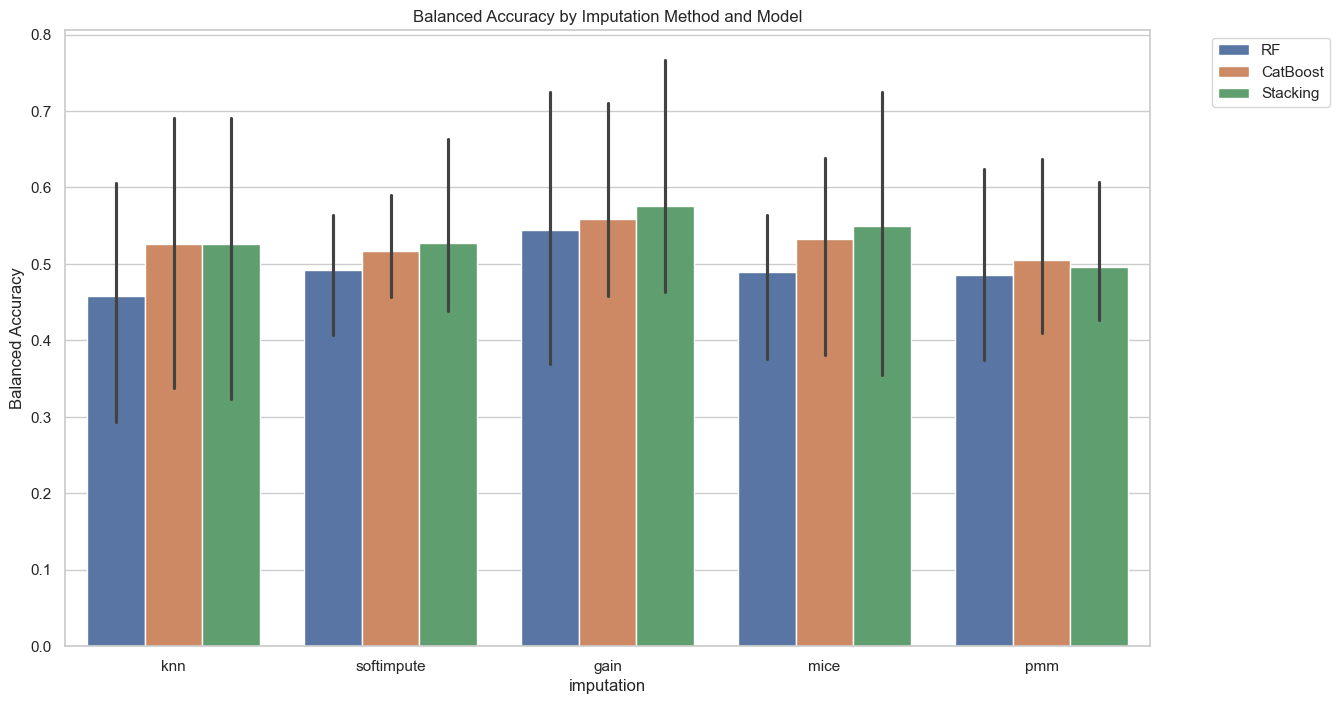

In [4]:
# Pivot results for better comparison
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='imputation', y='balanced_accuracy', hue='model')
plt.title('Balanced Accuracy by Imputation Method and Model')
plt.ylabel('Balanced Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

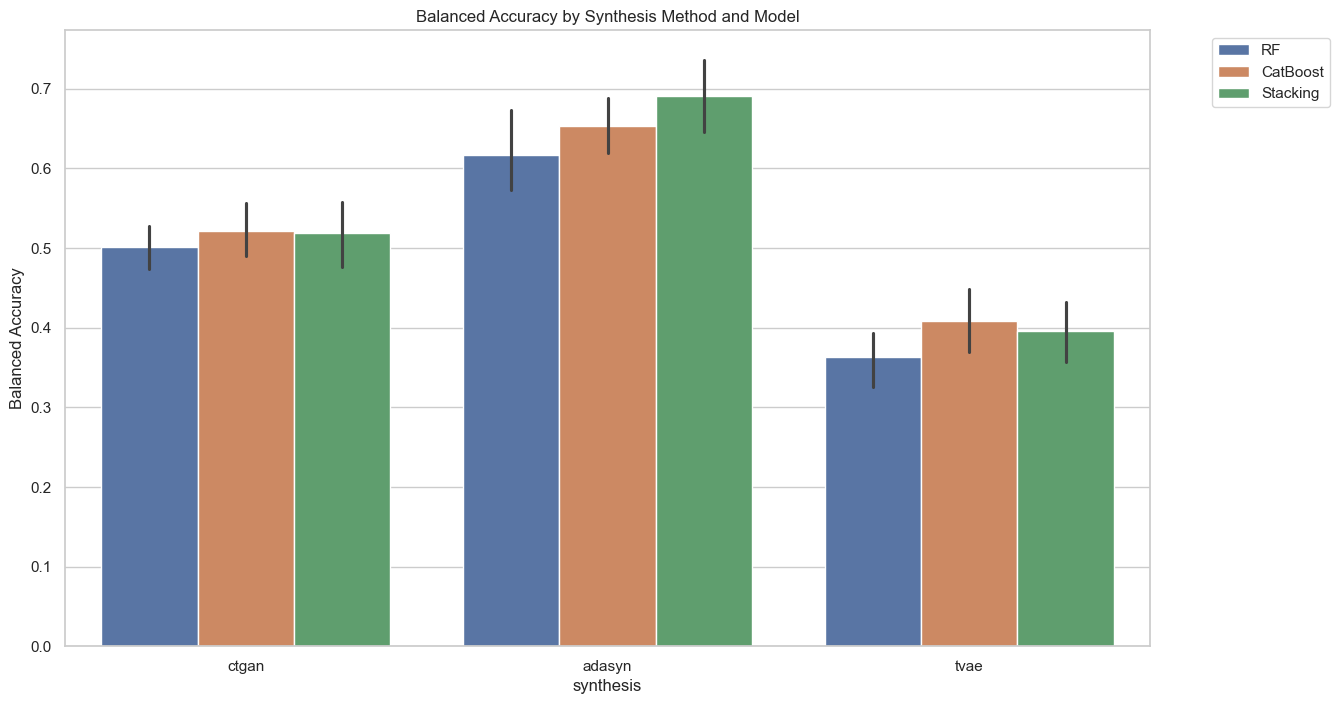

In [5]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='synthesis', y='balanced_accuracy', hue='model')
plt.title('Balanced Accuracy by Synthesis Method and Model')
plt.ylabel('Balanced Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 4. Best Performing Combination

In [6]:
best_row = results_df.sort_values(by='balanced_accuracy', ascending=False).iloc[0]
print("Best Performing Configuration:")
print(best_row)

print("\nTop 5 Overall:")
display(results_df.sort_values(by='balanced_accuracy', ascending=False).head(5))

Best Performing Configuration:
imputation               gain
synthesis              adasyn
model                Stacking
accuracy             0.774648
balanced_accuracy    0.767361
f1_weighted          0.771491
Name: 23, dtype: object

Top 5 Overall:


,imputation,synthesis,model,accuracy,balanced_accuracy,f1_weighted
23,gain,adasyn,Stacking,0.774648,0.767361,0.771491
21,gain,adasyn,RF,0.732394,0.725420,0.724099
32,mice,adasyn,Stacking,0.735294,0.724470,0.729725
22,gain,adasyn,CatBoost,0.718310,0.710069,0.706029
4,knn,adasyn,CatBoost,0.704225,0.690278,0.688573


## 5. Heatmap of Results (Stacking Model)

Let's see how the Stacking model performs across all combinations.

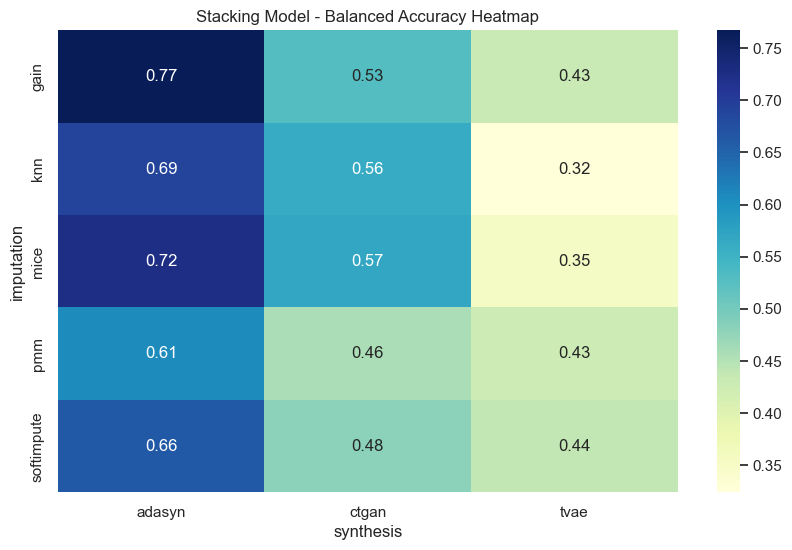

In [7]:
stacking_results = results_df[results_df['model'] == 'Stacking']
matrix = stacking_results.pivot(index='imputation', columns='synthesis', values='balanced_accuracy')

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap='YlGnBu')
plt.title('Stacking Model - Balanced Accuracy Heatmap')
plt.show()